### <center> Serial Shearlet Decomposition and Reconstruction </center>

In [1]:
# Clone the libraris
#Pkg.clone("https://github.com/arsenal9971/Shearlab.jl.git")

In [9]:
# Loard the Pkg
push!(LOAD_PATH,pwd()*"/../../src") 
import Shearlab
#using Shearlab
using PyPlot
#reload("Shearlab")

In [10]:
# Read Data
n = 512;
# The path of the image
name = "../../data_samples/bessyii.bmp";
data_nopar = Shearlab.load_image(name, n);
data_par = Shearlab.load_image(name, n,n,1);
#Rescale image in [0,1] summing the 3 arrays in the RGB format
data_nopar = Shearlab.rescale(sum(data_nopar,3));
data_par = Shearlab.rescale(sum(data_par,3));

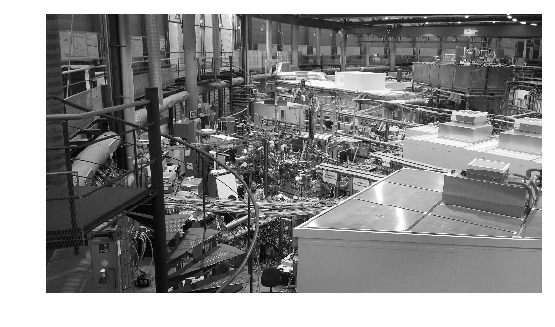

In [11]:
# Reduce one dimension 
data_nopar = data_nopar[:,:,1];
data_par = data_par[:,:,1];
Shearlab.imageplot(data_nopar);

#### Decomposition.

In [13]:
nScales = 4;

In [14]:
shearLevels = ceil((1:nScales)/2)
scalingFilter = Shearlab.filt_gen("scaling_shearlet");
directionalFilter = Shearlab.filt_gen("directional_shearlet");
waveletFilter = Shearlab.mirror(scalingFilter);
scalingFilter2 = scalingFilter;
quadratureMirrorFilter = scalingFilter;
full = 0;

In [29]:
# Prepare serial processing
@time preparedSerial_nopar = Shearlab.prepareserial2D(data_nopar,nScales,shearLevels, full,directionalFilter , quadratureMirrorFilter, 0); 

  6.985059 seconds (241.04 k allocations: 3.654 GB, 52.60% gc time)


In [30]:
# GPU version
using ArrayFire
data_par = AFArray(convert(Array{Float32},data_par));

In [31]:
@time preparedSerial_par= Shearlab.prepareserial2D(data_par,nScales,shearLevels, full,directionalFilter , quadratureMirrorFilter, 1); 

  2.218477 seconds (169.44 k allocations: 410.849 MB, 9.14% gc time)


In [32]:
preparedSerial = preparedSerial_nopar;

In [33]:
# Store variables
Xfreq = preparedSerial.Xfreq;
Xrec = preparedSerial.Xrec;
preparedFilters = preparedSerial.preparedFilters;
dualFrameWeightsCurr = preparedSerial.dualFrameWeightsCurr;
shearletIdxs = preparedSerial.shearletIdxs;

In [34]:
j = 1;
# Compute the serial decomposition 
shearletIdx = shearletIdxs[j,:]';
    
# Shearlet decomposition
shearletserial2D = Shearlab.sheardecserial2D(Xfreq, shearletIdx, preparedFilters,
                                             dualFrameWeightsCurr);
coefficients = shearletserial2D.coeffs;
shearlet = shearletserial2D.shearlet;
dualFrameWeightsCurr = shearletserial2D.dualFrameWeightsNew;
RMS = shearletserial2D.RMS;

In [35]:
for j in 1:size(shearletIdxs,1)
    shearletIdx = shearletIdxs[j,:]';
    
    # Shearlet decomposition
    shearletserial2D = Shearlab.sheardecserial2D(Xfreq, shearletIdx, preparedFilters,
                                                 dualFrameWeightsCurr);
    coefficients = shearletserial2D.coeffs;
    shearlet = shearletserial2D.shearlet;
    dualFrameWeightsCurr = shearletserial2D.dualFrameWeightsNew;
    RMS = shearletserial2D.RMS;
end      

#### Reconstruction

In [36]:
j = 1;
shearletIdx = shearletIdxs[j,:]';

#shearlet decomposition
shearletserial2D = Shearlab.sheardecserial2D(Xfreq, shearletIdx, preparedFilters,
                                              dualFrameWeightsCurr);
# Save variables
coefficients = shearletserial2D.coeffs;
shearlet = shearletserial2D.shearlet;
dualFrameWeightsCurr = shearletserial2D.dualFrameWeightsNew;
# Processing
Xrec = Shearlab.shearrecserial2D(coefficients, shearlet, Xrec);

In [37]:
for j in 1:size(shearletIdxs,1)
    shearletIdx = shearletIdxs[j,:]';
    
    #shearlet decomposition
    shearletserial2D = Shearlab.sheardecserial2D(Xfreq, shearletIdx, preparedFilters,
                                                  dualFrameWeightsCurr);
    # Save variables
    coefficients = shearletserial2D.coeffs;
    shearlet = shearletserial2D.shearlet;
    dualFrameWeightsCurr = shearletserial2D.dualFrameWeightsNew;
    
    # Processing
    Xrec = Shearlab.shearrecserial2D(coefficients, shearlet, Xrec);
end

In [38]:
reconstruction = Shearlab.finishserial2D(Xrec,dualFrameWeightsCurr);

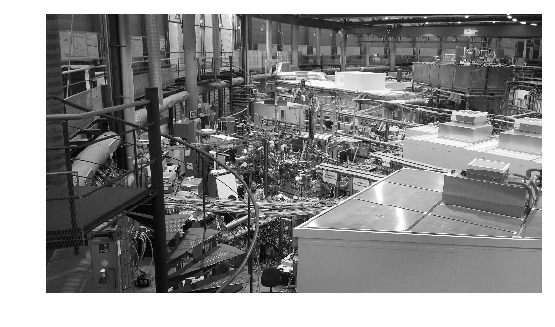

In [39]:
# Image
Shearlab.imageplot(Array(real(reconstruction)));